# Chapter 10: Logistic Regression

In [73]:
%matplotlib inline
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
import statsmodels.api as sm
import statsmodels.formula.api as smf
# pip install mord
from mord import LogisticIT
import matplotlib.pylab as plt
import seaborn as sns
from dmba import classificationSummary, gainsChart, liftChart
from dmba.metric import AIC_score
#Import math Library
import math

In [74]:
# pip install mord

In [75]:
# Euler number
math.exp(1)

2.718281828459045

In [76]:
math.e

2.718281828459045

In [77]:
# Natural log
math.log(2.718281828459045)

1.0

In [78]:
math.log(math.e)

1.0

In [79]:
# base 10 log
math.log(10, 10)

1.0

In [80]:
# raise 2.718281828459045 to the power of 0
2.718281828459045**0

1.0

In [81]:
# 1e3 is same as 10 to the power of 3
10**3

1000

In [82]:
10**(-3)

0.001

In [83]:
# Working directory:
#
# We assume that data are kept in the same directory as the notebook. If you keep your 
# data in a different folder, replace the argument of the `Path`
# DATA = Path('/Users/limin/Library/CloudStorage/OneDrive-Personal/teaching/DS110/dmba/')
DATA = Path('/Users/min/OneDrive/teaching/DS110/dmba/')
# DATA = Path('/Users/limin/OneDrive/teaching/DS110/dmba')
# DATA = Path('C:/Users/profm/OneDrive/teaching/DS110/dmba')
# and then load data using 
#
# pd.read_csv(DATA / ‘filename.csv’)

## Table 10.2
## Logistic Regression using <b>sklearn</b>'s <i>LogisticRegression</i> 
Load the `UniversalBank.csv` dataset. The columns `ID` and `ZIP Code` are not relevant for model building and therefore removed. Treat Education as categorical

In [84]:
bank_df = pd.read_csv(DATA / 'UniversalBank.csv')
bank_df.drop(columns=['ID', 'ZIP Code'], inplace=True)
bank_df.columns = [c.replace(' ', '_') for c in bank_df.columns]
bank_df

,Age,Experience,Income,Family,CCAvg,Education,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard
0,25,1,49,4,1.6,1,0,0,1,0,0,0
1,45,19,34,3,1.5,1,0,0,1,0,0,0
2,39,15,11,1,1.0,1,0,0,0,0,0,0
3,35,9,100,1,2.7,2,0,0,0,0,0,0
4,35,8,45,4,1.0,2,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
4995,29,3,40,1,1.9,3,0,0,0,0,1,0
4996,30,4,15,4,0.4,1,85,0,0,0,1,0
4997,63,39,24,2,0.3,3,0,0,0,0,0,0
4998,65,40,49,3,0.5,2,0,0,0,0,1,0


In [85]:
# Treat education as categorical, convert to dummy variables
bank_df['Education'] = bank_df['Education'].astype('category')
new_categories = {1: 'Undergrad', 2: 'Graduate', 3: 'Advanced/Professional'}
bank_df.Education.cat.rename_categories(new_categories)
bank_df

,Age,Experience,Income,Family,CCAvg,Education,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard
0,25,1,49,4,1.6,1,0,0,1,0,0,0
1,45,19,34,3,1.5,1,0,0,1,0,0,0
2,39,15,11,1,1.0,1,0,0,0,0,0,0
3,35,9,100,1,2.7,2,0,0,0,0,0,0
4,35,8,45,4,1.0,2,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
4995,29,3,40,1,1.9,3,0,0,0,0,1,0
4996,30,4,15,4,0.4,1,85,0,0,0,1,0
4997,63,39,24,2,0.3,3,0,0,0,0,0,0
4998,65,40,49,3,0.5,2,0,0,0,0,1,0


In [86]:
# logistic regression using Income only
predictors = ['Income']
outcome = 'Personal_Loan'
y = bank_df[outcome]
X = bank_df[predictors]

# partition data
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

# fit a logistic regression (set penalty=l2 and C=1e42 to avoid regularization)
logit_reg_income = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
logit_reg_income.fit(train_X, train_y)

print('intercept ', logit_reg_income.intercept_[0])
print(pd.DataFrame({'coefficient': logit_reg_income.coef_[0]}, index=X.columns).transpose())
print()
print('AIC', AIC_score(valid_y, logit_reg_income.predict(valid_X), df = len(train_X.columns) + 1))

intercept  -6.048919279034499
               Income
coefficient  0.036343

AIC 843.5163143186965


# Interpreting Results in Terms of Odds (for a Profiling Goal)

## Odds(Y=1)=exp(B_0+B_1 * x_1+B_2 * x_2+...+B_p * x_p (see equation 10.5)
## Odds(Personal Loan = Yes | Income) = exp(B_0 + B_1*Income)

### The <b><i>base-case odds</i></b> that a customers with income zero will accept the loan (Y=1) is calculated below:

In [87]:
math.exp(-6.04892+0.036*0)

0.002360409873057536

### The odds of accepting the loan with an income of $100K will increase by a multiplicative factor of exp (0.036*100)

In [88]:
math.exp(-6.04892+0.036*100)/math.exp(-6.04892+0.036*0)

36.598234443677974

In [89]:
math.exp(0.036*(100-0))

36.598234443677974

## The odds that a customer with an income of $100K will accept the offer are

In [90]:
math.exp(-6.04892+0.036*100)

0.08638683391733186

### Increase income by 1 unit

In [91]:
math.exp(-6.04892+0.036*2)/math.exp(-6.04892+0.036*1)

1.0366558464909243

In [92]:
math.exp(0.036)

1.0366558464909237

### Suppose that the value of Income, or in general X_1, is increased by one unit from x_1 to x_1+1, while the other predictors are held at their current value (x_2, ..., x_12). We get the odds ratio odds(x_1+1, x_2, ..., x_12)/odds(x_1, ..., x_12) = exp(B_1). In other words, a single unit increase in X_1, holding X_2, ..., X_12 constant, is associated with an increase in the odds that a customer accepts the offer by a factor of exp(B_1), the <i>multiplicative factor</i> by which the odds of belonging to class 1 increase when the value of X_1 is increased by 1 unit holding all other predictors constant.

In [93]:
# 0.058824 is the coefficient for Income as shown in Table 10.2 below
math.exp(0.058824)

1.0605885607261119

## We have similar interpretation when the predictor is a dummy variable, e.g., the coefficient for CD_Account in the 12-predictor model was estimated from the data to be:

In [94]:
math.exp(3.647933)

38.39522104900197

## The reference group is cutormers not holding a CD account. So 38 is odds that a customer who has a CD account will accept the offer relative to a customer who does not have a CD account, holding all other predictors constant. Customers who hold CD accounts at Universal Bank are more likely to accept the offer than customers without a CD account holding all other variables constant.

## Why do we report results in odds as opposed to probabilities? 
### The change in the probability, <i>p</i>, for a unit increase in a particular predictor variable, while holding all other predictors constant, is not a constant - it depends on the specific values of the predictor variables. We therefore talk about probabilities only in the context of specific records.

## Table 10.2
Predict to get the probabilities

In [95]:
bank_df = pd.get_dummies(bank_df, prefix_sep='_', drop_first=True)

y = bank_df['Personal_Loan']
X = bank_df.drop(columns=['Personal_Loan'])

# partition data
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

# fit a logistic regression (set penalty=l2 and C=1e42 to avoid regularization)
# see https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
# see https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
logit_reg = LogisticRegression(penalty="l2", C=1e42, solver='liblinear', random_state=1)
logit_reg.fit(train_X, train_y)

print('intercept ', logit_reg.intercept_[0])
print(pd.DataFrame({'coeff': logit_reg.coef_[0]}, index=X.columns).transpose())
print()
print('AIC', AIC_score(valid_y, logit_reg.predict(valid_X), df = len(train_X.columns) + 1))

intercept  -12.613544176472766
            Age  Experience    Income    Family     CCAvg  Mortgage  \
coeff -0.032529    0.034125  0.058836  0.613192  0.239471   0.00101   

       Securities_Account  CD_Account    Online  CreditCard  Education_2  \
coeff            -1.02654    3.646909 -0.678735   -0.955959     4.191023   

       Education_3  
coeff     4.341131  

AIC -709.1524769205962


In [96]:
logit_reg_pred = logit_reg.predict(valid_X)
logit_reg_pred

array([0, 0, 0, ..., 0, 0, 0])

In [97]:
logit_reg_proba = logit_reg.predict_proba(valid_X)
logit_reg_proba

array([[9.76110804e-01, 2.38891963e-02],
       [9.99936645e-01, 6.33547838e-05],
       [9.99899198e-01, 1.00802050e-04],
       ...,
       [9.99790100e-01, 2.09900334e-04],
       [9.98461729e-01, 1.53827149e-03],
       [9.92706630e-01, 7.29337006e-03]])

In [98]:
9.76243003e-01 + 2.37569968e-02

0.9999999998

In [99]:
9.92839442e-01 + 7.16055789e-03

0.99999999989

In [100]:
logit_reg_lbfgs = LogisticRegression(penalty="l2", C=1e42, solver='lbfgs', max_iter=10000)
logit_reg_lbfgs.fit(train_X, train_y)

print('intercept ', logit_reg_lbfgs.intercept_[0])
print(pd.DataFrame({'coeff': logit_reg_lbfgs.coef_[0]}, index=X.columns).transpose())
print()
print('AIC', AIC_score(valid_y, logit_reg_lbfgs.predict(valid_X), df = len(train_X.columns) + 1))

intercept  -12.356811963743377
           Age  Experience    Income    Family     CCAvg  Mortgage  \
coeff -0.04138    0.042775  0.058667  0.609951  0.240642  0.001009   

       Securities_Account  CD_Account    Online  CreditCard  Education_2  \
coeff           -1.033788    3.655886 -0.683489   -0.960042     4.194067   

       Education_3  
coeff     4.336848  

AIC -709.1524769205962


In [101]:
# Use the default solver lbfgs without penalty
logit_reg2 = LogisticRegression(penalty='none', max_iter=10000)
logit_reg2.fit(train_X, train_y)

print('intercept ', logit_reg2.intercept_[0])
print(pd.DataFrame({'coeff': logit_reg2.coef_[0]}, index=X.columns).transpose())
print()
print('AIC', AIC_score(valid_y, logit_reg2.predict(valid_X), df = len(train_X.columns) + 1))

intercept  -12.356811963743377
           Age  Experience    Income    Family     CCAvg  Mortgage  \
coeff -0.04138    0.042775  0.058667  0.609951  0.240642  0.001009   

       Securities_Account  CD_Account    Online  CreditCard  Education_2  \
coeff           -1.033788    3.655886 -0.683489   -0.960042     4.194067   

       Education_3  
coeff     4.336848  

AIC -709.1524769205962


In [102]:
# Use the default solver lbfgs without penalty
logit_reg2 = LogisticRegression(penalty='none', max_iter=10000)
logit_reg2.fit(train_X, train_y)

print('intercept ', logit_reg2.intercept_[0])
print(pd.DataFrame({'coeff': logit_reg2.coef_[0]}, index=X.columns).transpose())
print()
print('AIC', AIC_score(valid_y, logit_reg2.predict(valid_X), df = len(train_X.columns) + 1))

intercept  -12.356811963743377
           Age  Experience    Income    Family     CCAvg  Mortgage  \
coeff -0.04138    0.042775  0.058667  0.609951  0.240642  0.001009   

       Securities_Account  CD_Account    Online  CreditCard  Education_2  \
coeff           -1.033788    3.655886 -0.683489   -0.960042     4.194067   

       Education_3  
coeff     4.336848  

AIC -709.1524769205962


In [103]:
# Use the default solver lbfgs without penalty
# increase default tolerance for stopping criteria 1e-4 to lower tolerance
logit_reg2 = LogisticRegression(penalty='none', max_iter=10000, tol=1e-8)
logit_reg2.fit(train_X, train_y)
print('intercept ', logit_reg2.intercept_[0])
print(pd.DataFrame({'coeff': logit_reg2.coef_[0]}, index=X.columns).transpose())
print()
print('AIC', AIC_score(valid_y, logit_reg2.predict(valid_X), df = len(train_X.columns) + 1))

intercept  -12.356811963743377
           Age  Experience    Income    Family     CCAvg  Mortgage  \
coeff -0.04138    0.042775  0.058667  0.609951  0.240642  0.001009   

       Securities_Account  CD_Account    Online  CreditCard  Education_2  \
coeff           -1.033788    3.655886 -0.683489   -0.960042     4.194067   

       Education_3  
coeff     4.336848  

AIC -709.1524769205962


### statsmodels

In [104]:
# see https://www.statsmodels.org/stable/examples/index.html#generalized-linear-models
# same initial preprocessing and creating dummies
# add constant column
bank_df = pd.get_dummies(bank_df, prefix_sep='_', drop_first=True)

y = bank_df['Personal_Loan']
X = bank_df.drop(columns=['Personal_Loan'])

# partition data
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)
train_X_sm = sm.add_constant(train_X, prepend=True)
logit_reg_sm = sm.GLM(train_y, train_X_sm, family=sm.families.Binomial())
logit_result_sm = logit_reg_sm.fit()
logit_result_sm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:          Personal_Loan   No. Observations:                 3000
Model:                            GLM   Df Residuals:                     2987
Model Family:                Binomial   Df Model:                           12
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -340.15
Date:                Thu, 23 Feb 2023   Deviance:                       680.30
Time:                        23:44:49   Pearson chi2:                 8.10e+03
No. Iterations:                     8   Pseudo R-squ. (CS):             0.3325
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                -12.5634      2.336     -5.377      0.000     -17.143      -7.984
Age                   -0.0354      0.086     -0.412      0.680      -0.204       0.133
Experience             0.0369      0.086      0.431      0.666      -0.131       0.205
Income                 0.0589      0.004     15.044      0.000       0.051       0.067
Family                 0.6128      0.103      5.931      0.000       0.410       0.815
CCAvg                  0.2408      0.060      4.032      0.000       0.124       0.358
Mortgage               0.0010      0.001      1.301      0.193      -0.001       0.003
Securities_Account    -1.0305      0.422     -2.443      0.015      -1.857      -0.204
CD_Account             3.6628      0.460      7.961      0.000       2.761       4.565
Online                -0.6794      0.216     -3.140      0.002      -1.103      -0.255
CreditCard            -0.9609      0.274     -3.507      0.000      -1.498      -0.424
Education_2            4.2075      0.364     11.573      0.000       3.495       4.920
Education_3            4.3580      0.365     11.937      0.000       3.642       5.074
======================================================================================
"""

In [105]:
# increase default tolerance for stopping criteria 1e-4 to lower tolerance
logit_reg = LogisticRegression(penalty="l2", C=1e42, solver='liblinear', tol=1e-8)
logit_reg.fit(train_X, train_y)
print('intercept ', logit_reg.intercept_[0])
print(pd.DataFrame({'coeff': logit_reg.coef_[0]}, index=X.columns).transpose())
print()
print('AIC', AIC_score(valid_y, logit_reg.predict(valid_X), df = len(train_X.columns) + 1))

intercept  -12.563420106960631
            Age  Experience    Income   Family     CCAvg  Mortgage  \
coeff -0.035384     0.03694  0.058903  0.61278  0.240769  0.001014   

       Securities_Account  CD_Account    Online  CreditCard  Education_2  \
coeff           -1.030543    3.662762 -0.679423   -0.960865     4.207534   

       Education_3  
coeff     4.358008  

AIC -733.9975169177105


## Table 10.3

In [106]:
logit_result = pd.DataFrame({'actual': valid_y, 
                             'p(0)': [p[0] for p in logit_reg_proba],
                             'p(1)': [p[1] for p in logit_reg_proba],
                             'predicted': logit_reg_pred })

# display four different cases
interestingCases = [2764, 932, 2721, 702]
print(logit_result.loc[interestingCases])

      actual      p(0)      p(1)  predicted
2764       0  0.976111  0.023889          0
932        0  0.334961  0.665039          1
2721       1  0.031752  0.968248          1
702        1  0.985717  0.014283          0


## Table 10.4

In [107]:
classificationSummary(train_y, logit_reg.predict(train_X))

Confusion Matrix (Accuracy 0.9603)

       Prediction
Actual    0    1
     0 2684   29
     1   90  197


In [108]:
classificationSummary(valid_y, logit_reg.predict(valid_X))

Confusion Matrix (Accuracy 0.9600)

       Prediction
Actual    0    1
     0 1791   16
     1   64  129


## Figure 10.3

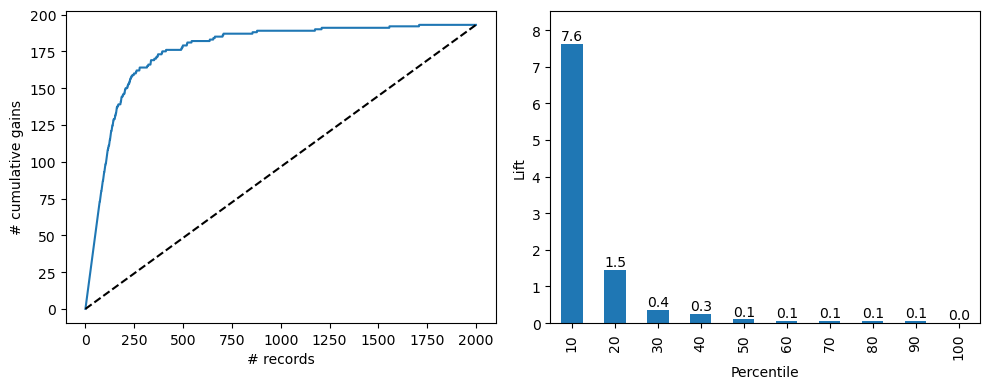

In [109]:
df = logit_result.sort_values(by=['p(1)'], ascending=False)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

gainsChart(df.actual, ax=axes[0])
liftChart(df.actual, title=False, ax=axes[1])
    
plt.tight_layout()
plt.show()

In [110]:
df.actual

3373    1
2217    1
787     1
47      1
3006    1
       ..
1100    0
4922    0
1720    0
3125    0
551     0
Name: actual, Length: 2000, dtype: int64

## Logistic Regression using STATMODELS <i>sm.glm</i> or <i>smf.glm</i>
Similar to R's glm()<br>
Results match R's output<br>
More extensive output of the statistical properties suitable for non-predictive tasks such as statistical inference.<br>
For regularization, use STATMODELS method Logit.fit_regularized (L1 penalty): https://tedboy.github.io/statsmodels_doc/generated/generated/statsmodels.api.Logit.fit_regularized.html<br>
It's better to use STATMODELS for well-behaved data (see Page 257) so the results match other statistical software like R or SAS.

In [111]:
bank_df

,Age,Experience,Income,Family,CCAvg,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard,Education_2,Education_3
0,25,1,49,4,1.6,0,0,1,0,0,0,0,0
1,45,19,34,3,1.5,0,0,1,0,0,0,0,0
2,39,15,11,1,1.0,0,0,0,0,0,0,0,0
3,35,9,100,1,2.7,0,0,0,0,0,0,1,0
4,35,8,45,4,1.0,0,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,29,3,40,1,1.9,0,0,0,0,1,0,0,1
4996,30,4,15,4,0.4,85,0,0,0,1,0,0,0
4997,63,39,24,2,0.3,0,0,0,0,0,0,0,1
4998,65,40,49,3,0.5,0,0,0,0,1,0,1,0


In [112]:
# see https://www.statsmodels.org/stable/examples/index.html#generalized-linear-models
# same initial preprocessing and creating dummies
# add constant column
bank_df2 = sm.add_constant(bank_df, prepend=True)
bank_df2.columns = [s.strip().replace('/', '_') for s in bank_df2.columns]
# Results using the entire data for comparison with sklearn or R
y2 = bank_df2['Personal_Loan']
X2 = bank_df2.drop(columns=['Personal_Loan'])
logit_reg2 = sm.GLM(y2, X2, family=sm.families.Binomial())
logit_result2 = logit_reg2.fit()
logit_result2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:          Personal_Loan   No. Observations:                 5000
Model:                            GLM   Df Residuals:                     4987
Model Family:                Binomial   Df Model:                           12
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -586.15
Date:                Thu, 23 Feb 2023   Deviance:                       1172.3
Time:                        23:44:54   Pearson chi2:                 1.70e+04
No. Iterations:                     8   Pseudo R-squ. (CS):             0.3283
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                -12.3105      1.818     -6.773      0.000     -15.873      -8.748
Age                   -0.0359      0.067     -0.534      0.593      -0.168       0.096
Experience             0.0450      0.067      0.674      0.500      -0.086       0.176
Income                 0.0602      0.003     20.289      0.000       0.054       0.066
Family                 0.6182      0.077      8.024      0.000       0.467       0.769
CCAvg                  0.1634      0.044      3.708      0.000       0.077       0.250
Mortgage               0.0007      0.001      1.196      0.232      -0.000       0.002
Securities_Account    -0.8701      0.301     -2.894      0.004      -1.459      -0.281
CD_Account             3.8389      0.342     11.239      0.000       3.169       4.508
Online                -0.7605      0.166     -4.589      0.000      -1.085      -0.436
CreditCard            -1.0382      0.213     -4.872      0.000      -1.456      -0.621
Education_2            3.9654      0.270     14.708      0.000       3.437       4.494
Education_3            4.0641      0.267     15.225      0.000       3.541       4.587
======================================================================================
"""

In [113]:
# Matching results from sklearn's liblinear
# increase default tolerance for stopping criteria 1e-4 to lower tolerance
logit_reg2 = LogisticRegression(penalty="l2", C=1e42, solver='liblinear', tol=1e-8)
logit_reg2.fit(X, y)
print('intercept ', logit_reg2.intercept_[0])
print(pd.DataFrame({'coeff': logit_reg2.coef_[0]}, index=X.columns).transpose())
print()
print('AIC', AIC_score(y, logit_reg2.predict(X), df = len(X.columns) + 1))

intercept  -12.310555114233567
            Age  Experience    Income    Family     CCAvg  Mortgage  \
coeff -0.035917    0.045038  0.060183  0.618169  0.163351  0.000711   

       Securities_Account  CD_Account    Online  CreditCard  Education_2  \
coeff           -0.870134     3.83892 -0.760529   -1.038199     3.965382   

       Education_3  
coeff     4.064057  

AIC -1753.5307293424194


In [114]:
# Results not matching using sklearn's default solver lbfgs without penalty
# increase default tolerance for stopping criteria 1e-4 to lower tolerance
logit_reg2 = LogisticRegression(penalty='none', max_iter=10000, tol=1e-8)
logit_reg2.fit(X, y)
print('intercept ', logit_reg2.intercept_[0])
print(pd.DataFrame({'coeff': logit_reg2.coef_[0]}, index=X.columns).transpose())
print()
print('AIC', AIC_score(y, logit_reg2.predict(X), df = len(X.columns) + 1))

intercept  -12.2632408648523
            Age  Experience    Income    Family     CCAvg  Mortgage  \
coeff -0.038102    0.047215  0.060214  0.616997  0.164216  0.000713   

       Securities_Account  CD_Account  Online  CreditCard  Education_2  \
coeff           -0.883997    3.855346 -0.7632   -1.046543     3.974106   

       Education_3  
coeff     4.076098  

AIC -1753.5307293424194


In [115]:
# Results not matching exactly using sklearn's solver newton-cg without penalty on Macbook Pro
# Rounding error on iMac Pro
# increase default tolerance for stopping criteria 1e-4 to lower tolerance
logit_reg2 = LogisticRegression(penalty='none', solver='newton-cg', max_iter=10000, tol=1e-8)
logit_reg2.fit(X, y)
print('intercept ', logit_reg2.intercept_[0])
print(pd.DataFrame({'coeff': logit_reg2.coef_[0]}, index=X.columns).transpose())
print()
print('AIC', AIC_score(y, logit_reg2.predict(X), df = len(X.columns) + 1))

intercept  -12.310548883957155
            Age  Experience    Income    Family     CCAvg  Mortgage  \
coeff -0.035917    0.045038  0.060183  0.618169  0.163351  0.000711   

       Securities_Account  CD_Account    Online  CreditCard  Education_2  \
coeff           -0.870136    3.838922 -0.760529     -1.0382     3.965378   

       Education_3  
coeff     4.064054  

AIC -1753.5307293424194


/Users/min/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:437: LineSearchWarning: Rounding errors prevent the line search from converging
  warn(msg, LineSearchWarning)
/Users/min/opt/anaconda3/lib/python3.9/site-packages/scipy/optimize/linesearch.py:327: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/min/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


In [116]:
# partition data
train_X2, valid_X2, train_y2, valid_y2 = train_test_split(X2, y2, test_size=0.4, random_state=1)
logit_reg2 = sm.GLM(train_y2, train_X2, family=sm.families.Binomial())
logit_result2 = logit_reg2.fit()
logit_result2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:          Personal_Loan   No. Observations:                 3000
Model:                            GLM   Df Residuals:                     2987
Model Family:                Binomial   Df Model:                           12
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -340.15
Date:                Thu, 23 Feb 2023   Deviance:                       680.30
Time:                        23:44:55   Pearson chi2:                 8.10e+03
No. Iterations:                     8   Pseudo R-squ. (CS):             0.3325
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                -12.5634      2.336     -5.377      0.000     -17.143      -7.984
Age                   -0.0354      0.086     -0.412      0.680      -0.204       0.133
Experience             0.0369      0.086      0.431      0.666      -0.131       0.205
Income                 0.0589      0.004     15.044      0.000       0.051       0.067
Family                 0.6128      0.103      5.931      0.000       0.410       0.815
CCAvg                  0.2408      0.060      4.032      0.000       0.124       0.358
Mortgage               0.0010      0.001      1.301      0.193      -0.001       0.003
Securities_Account    -1.0305      0.422     -2.443      0.015      -1.857      -0.204
CD_Account             3.6628      0.460      7.961      0.000       2.761       4.565
Online                -0.6794      0.216     -3.140      0.002      -1.103      -0.255
CreditCard            -0.9609      0.274     -3.507      0.000      -1.498      -0.424
Education_2            4.2075      0.364     11.573      0.000       3.495       4.920
Education_3            4.3580      0.365     11.937      0.000       3.642       5.074
======================================================================================
"""

In [117]:
# Without penalty, results still don't match statsmodels
logit_reg2 = LogisticRegression(penalty='none', max_iter=10000, tol=1e-8)
logit_reg2.fit(train_X2.drop(columns=('const')), train_y2)

print('intercept ', logit_reg2.intercept_[0])
print(pd.DataFrame({'coeff': logit_reg2.coef_[0]}, index=X.columns).transpose())
print()
print('AIC', AIC_score(valid_y, logit_reg2.predict(valid_X), df = len(train_X.columns) + 1))

intercept  -12.356811963743377
           Age  Experience    Income    Family     CCAvg  Mortgage  \
coeff -0.04138    0.042775  0.058667  0.609951  0.240642  0.001009   

       Securities_Account  CD_Account    Online  CreditCard  Education_2  \
coeff           -1.033788    3.655886 -0.683489   -0.960042     4.194067   

       Education_3  
coeff     4.336848  

AIC -709.1524769205962


In [118]:
train_X2

,const,Age,Experience,Income,Family,CCAvg,Mortgage,Securities_Account,CD_Account,Online,CreditCard,Education_2,Education_3
4522,1.0,31,5,29,1,0.3,0,0,0,0,0,0,0
2851,1.0,61,36,81,3,1.8,0,0,0,1,0,1,0
2313,1.0,58,32,54,3,0.3,0,0,0,1,1,1,0
982,1.0,58,33,52,3,0.5,0,0,0,0,1,1,0
1164,1.0,41,17,94,3,3.8,327,1,1,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2895,1.0,60,36,39,4,1.3,140,0,0,1,0,1,0
2763,1.0,55,31,13,4,0.7,0,0,0,1,0,0,0
905,1.0,46,22,28,1,1.0,84,0,0,1,1,0,0
3980,1.0,46,22,89,4,1.4,0,0,0,1,0,1,0


In [119]:
# see https://www.statsmodels.org/stable/examples/index.html#generalized-linear-models
# see https://www.statsmodels.org/stable/examples/notebooks/generated/glm_formula.html
df = pd.concat([train_y2, train_X2], axis=1)
formula = 'Personal_Loan ~ Age+Experience+Income+Family+CCAvg+Mortgage+Securities_Account+\
CD_Account+Online+CreditCard+Education_2+Education_3'
model = smf.glm(formula=formula, data=df, family=sm.families.Binomial()).fit()

In [120]:
print(model.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:          Personal_Loan   No. Observations:                 3000
Model:                            GLM   Df Residuals:                     2987
Model Family:                Binomial   Df Model:                           12
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -340.15
Date:                Thu, 23 Feb 2023   Deviance:                       680.30
Time:                        23:44:57   Pearson chi2:                 8.10e+03
No. Iterations:                     8   Pseudo R-squ. (CS):             0.3325
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            -12.5634      2

In [121]:
df = pd.concat([train_y2, train_X2], axis=1)
model = smf.glm('Personal_Loan ~ Age+Experience+Income+Family+CCAvg+Mortgage+Securities_Account+\
CD_Account+Online+CreditCard+Education_2+Education_3', \
                data=df, family=sm.families.Binomial())
result = model.fit()
print(result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:          Personal_Loan   No. Observations:                 3000
Model:                            GLM   Df Residuals:                     2987
Model Family:                Binomial   Df Model:                           12
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -340.15
Date:                Thu, 23 Feb 2023   Deviance:                       680.30
Time:                        23:44:58   Pearson chi2:                 8.10e+03
No. Iterations:                     8   Pseudo R-squ. (CS):             0.3325
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            -12.5634      2

In [122]:
print("Coefficeients")
print(result.params)
print()
print("p-Values")
print(result.pvalues)
print()
print("Dependent variables")
print(result.model.endog_names)

Coefficeients
Intercept            -12.563415
Age                   -0.035385
Experience             0.036941
Income                 0.058903
Family                 0.612780
CCAvg                  0.240769
Mortgage               0.001014
Securities_Account    -1.030544
CD_Account             3.662765
Online                -0.679423
CreditCard            -0.960866
Education_2            4.207538
Education_3            4.358011
dtype: float64

p-Values
Intercept             7.569697e-08
Age                   6.804652e-01
Experience            6.661812e-01
Income                3.778437e-51
Family                3.013430e-09
CCAvg                 5.534269e-05
Mortgage              1.933156e-01
Securities_Account    1.455225e-02
CD_Account            1.704307e-15
Online                1.686918e-03
CreditCard            4.533918e-04
Education_2           5.663104e-31
Education_3           7.556383e-33
dtype: float64

Dependent variables
Personal_Loan


In [123]:
valid_X2

,const,Age,Experience,Income,Family,CCAvg,Mortgage,Securities_Account,CD_Account,Online,CreditCard,Education_2,Education_3
2764,1.0,31,5,84,1,2.9,105,0,0,0,1,0,1
4767,1.0,35,9,45,3,0.9,101,1,0,0,0,0,0
3814,1.0,34,9,35,3,1.3,0,0,0,0,0,0,0
3499,1.0,49,23,114,1,0.3,286,0,0,1,0,0,0
2735,1.0,36,12,70,3,2.6,165,0,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4372,1.0,34,10,41,1,2.4,0,0,0,0,0,1,0
3401,1.0,39,15,28,1,1.4,118,0,0,1,1,0,1
1239,1.0,51,26,12,2,0.7,109,0,0,1,1,0,1
437,1.0,36,9,31,4,1.0,0,1,0,1,0,1,0


In [124]:
predictions = result.predict(valid_X2)
predictions

2764    0.023819
4767    0.000062
3814    0.000099
3499    0.001598
2735    0.042656
          ...   
4372    0.003744
3401    0.000352
1239    0.000208
437     0.001517
415     0.007230
Length: 2000, dtype: float64

## Table 10.3
Predict to get the probabilities

In [125]:
predictions = result.predict(valid_X2)
predictions_nominal = [ 0 if x < 0.5 else 1 for x in predictions]
logit_result = pd.DataFrame({'actual': valid_y2, 
                             'p(0)': 1 - predictions,
                             'p(1)': predictions,
                             'predicted': predictions_nominal })

# display four different cases
interestingCases = [2764, 932, 2721, 702]
print(logit_result.loc[interestingCases])

      actual      p(0)      p(1)  predicted
2764       0  0.976181  0.023819          0
932        0  0.332320  0.667680          1
2721       1  0.031333  0.968667          1
702        1  0.985902  0.014098          0


## Table 10.4

In [126]:
predictions = result.predict()
predictions_nominal = [ 0 if x < 0.5 else 1 for x in predictions]

In [127]:
# training confusion matrix
classificationSummary(train_y2, predictions_nominal)

Confusion Matrix (Accuracy 0.9603)

       Prediction
Actual    0    1
     0 2684   29
     1   90  197


In [128]:
# validation confusion matrix
predictions = result.predict(valid_X2)
predictions_nominal = [ 0 if x < 0.5 else 1 for x in predictions]
classificationSummary(valid_y2, predictions_nominal)

Confusion Matrix (Accuracy 0.9600)

       Prediction
Actual    0    1
     0 1791   16
     1   64  129


## Figure 10.3

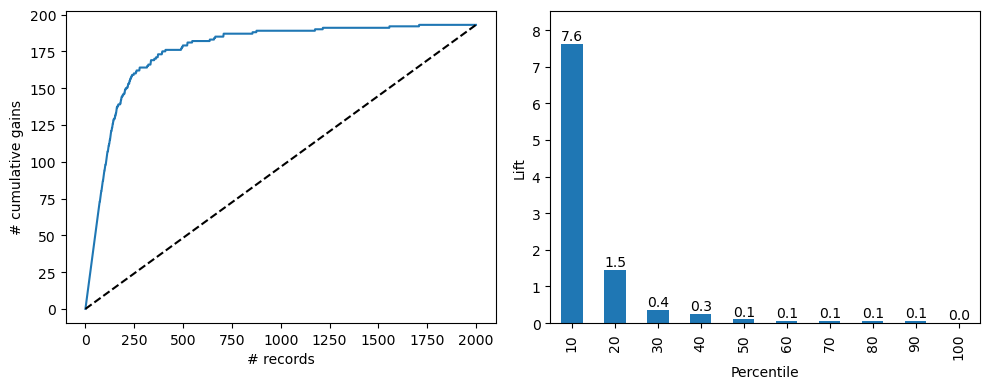

In [129]:
df = logit_result.sort_values(by=['p(1)'], ascending=False)
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 4))

gainsChart(df.actual, ax=axes[0])
liftChart(df.actual, title=False, ax=axes[1])
    
plt.tight_layout()
plt.show()

## Table 10.5

In [130]:
data = pd.read_csv(DATA / 'accidentsFull.csv')
outcome = 'MAX_SEV_IR'
predictors = ['ALCHL_I', 'WEATHER_R']
y = data[outcome]
X = data[predictors]
train_X, train_y = X, y
print('Nominal logistic regression')
logit = LogisticRegression(penalty="l2", solver='lbfgs',
C=1e24, multi_class='multinomial')
logit.fit(X, y)
print(' intercept', logit.intercept_)
print(' coefficients', logit.coef_)
print()
probs = logit.predict_proba(X)
results = pd.DataFrame({
'actual': y, 'predicted': logit.predict(X),
'P(0)': [p[0] for p in probs],
'P(1)': [p[1] for p in probs],
'P(2)': [p[2] for p in probs],
})
print(results.head())
print()
print('Ordinal logistic regression')
# see https://pythonhosted.org/mord/reference.html#mord.LogisticIT
logit = LogisticIT(alpha=0) 
logit.fit(X, y)
print(' theta', logit.theta_)
print(' coefficients', logit.coef_)
print()
probs = logit.predict_proba(X)
results = pd.DataFrame({
'actual': y, 'predicted': logit.predict(X),
'P(0)': [p[0] for p in probs],
'P(1)': [p[1] for p in probs],
'P(2)': [p[2] for p in probs],
})
print(results.head())

Nominal logistic regression
 intercept [-0.09100315  0.9036454  -0.81264225]
 coefficients [[ 0.51606685  0.3391015 ]
 [ 0.14900396  0.09543369]
 [-0.66507082 -0.43453518]]

   actual  predicted      P(0)      P(1)      P(2)
0       1          1  0.490649  0.498989  0.010362
1       0          0  0.553461  0.441147  0.005392
2       0          0  0.553461  0.441147  0.005392
3       0          1  0.490649  0.498989  0.010362
4       0          1  0.394192  0.578684  0.027124

Ordinal logistic regression
 theta [-1.06916285  2.77444326]
 coefficients [-0.40112008 -0.25174207]

   actual  predicted      P(0)      P(1)      P(2)
0       1          1  0.496205  0.482514  0.021281
1       0          0  0.558866  0.424510  0.016624
2       0          0  0.558866  0.424510  0.016624
3       0          1  0.496205  0.482514  0.021281
4       0          1  0.397402  0.571145  0.031453


## 10.6 EXAMPLE OF COMPLETE ANALYSIS PREDICTING DELAYED FLIGHTS
### Goal 1: 
<b><i>Classification</i></b> of new flights - classify new flights based on their predictors.
### Goal 2: 
<b><i>Ranking</i></b> - find a certain percentage of flights that are most/least likely to get delayed.
### Goal 3: 
<b><i>Profiling</i></b> flights - find out which factors are associated with a delay and quantify these effects.

## Figure 10.4

In [131]:
delays_df = pd.read_csv(DATA / 'FlightDelays.csv')
delays_df

,CRS_DEP_TIME,CARRIER,DEP_TIME,DEST,DISTANCE,FL_DATE,FL_NUM,ORIGIN,Weather,DAY_WEEK,DAY_OF_MONTH,TAIL_NUM,Flight Status
0,1455,OH,1455,JFK,184,01/01/2004,5935,BWI,0,4,1,N940CA,ontime
1,1640,DH,1640,JFK,213,01/01/2004,6155,DCA,0,4,1,N405FJ,ontime
2,1245,DH,1245,LGA,229,01/01/2004,7208,IAD,0,4,1,N695BR,ontime
3,1715,DH,1709,LGA,229,01/01/2004,7215,IAD,0,4,1,N662BR,ontime
4,1039,DH,1035,LGA,229,01/01/2004,7792,IAD,0,4,1,N698BR,ontime
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2196,645,RU,644,EWR,199,1/31/2004,2761,DCA,0,6,31,N15555,ontime
2197,1700,RU,1653,EWR,213,1/31/2004,2497,IAD,0,6,31,N16976,ontime
2198,1600,RU,1558,EWR,199,1/31/2004,2361,DCA,0,6,31,N14902,ontime
2199,1359,RU,1403,EWR,199,1/31/2004,2216,DCA,0,6,31,N16961,ontime


In [132]:
delays_df.columns

Index(['CRS_DEP_TIME', 'CARRIER', 'DEP_TIME', 'DEST', 'DISTANCE', 'FL_DATE',
       'FL_NUM', 'ORIGIN', 'Weather', 'DAY_WEEK', 'DAY_OF_MONTH', 'TAIL_NUM',
       'Flight Status'],
      dtype='object')

In [133]:
delays_df['Flight Status'].value_counts()

ontime     1773
delayed     428
Name: Flight Status, dtype: int64

In [134]:
428/(1773+428)

0.19445706497046797

In [135]:
delays_df['CARRIER'].value_counts()

DH    551
RU    408
US    404
DL    388
MQ    295
CO     94
UA     31
OH     30
Name: CARRIER, dtype: int64

In [136]:
delays_df['ORIGIN'].value_counts()

DCA    1370
IAD     686
BWI     145
Name: ORIGIN, dtype: int64

In [137]:
delays_df['DEST'].value_counts()

LGA    1150
EWR     665
JFK     386
Name: DEST, dtype: int64

In [138]:
delays_df['DAY_WEEK'].value_counts()

5    391
4    372
3    320
1    308
2    307
7    253
6    250
Name: DAY_WEEK, dtype: int64

In [139]:
delays_df['Weather'].value_counts()

0    2169
1      32
Name: Weather, dtype: int64

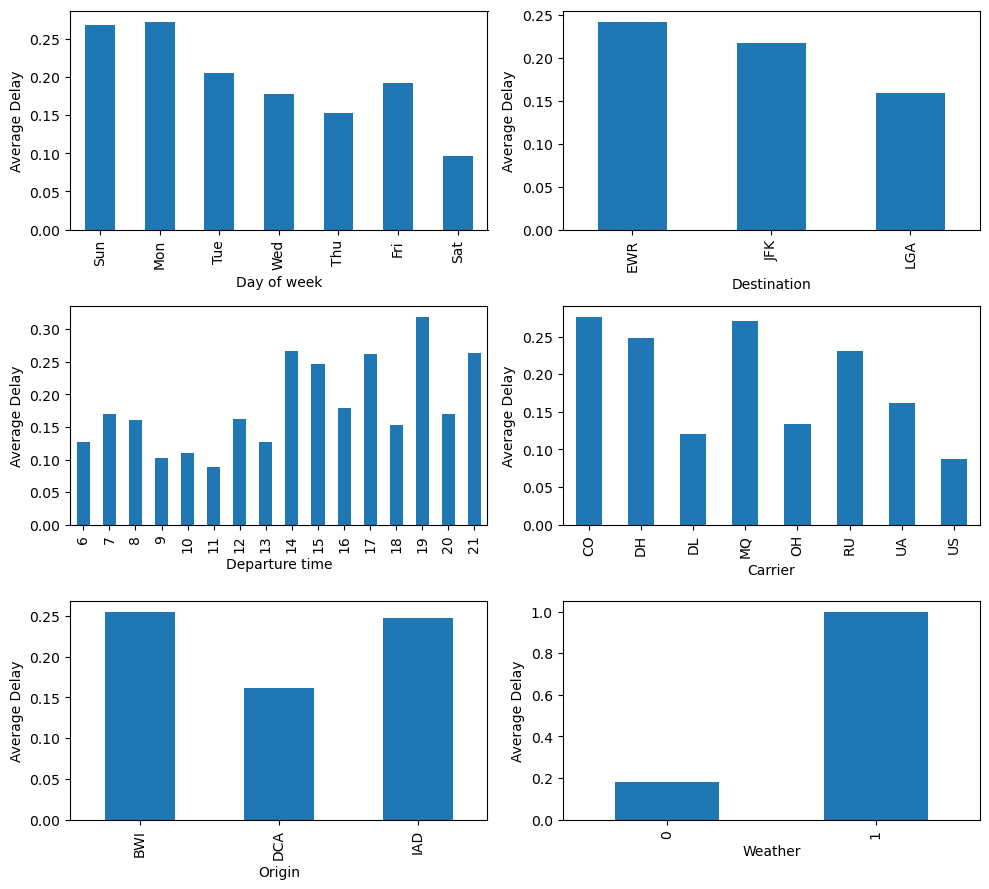

In [140]:
delays_df = pd.read_csv(DATA / 'FlightDelays.csv')
# Create an indicator variable
delays_df['isDelayed'] = [1 if status == 'delayed' else 0 
                          for status in delays_df['Flight Status']]

def createGraph(group, xlabel, axis):
    groupAverage = delays_df.groupby([group])['isDelayed'].mean()
    if group == 'DAY_WEEK': # rotate so that display starts on Sunday
        groupAverage = groupAverage.reindex(index=np.roll(groupAverage.index,1))
        groupAverage.index = ['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat']
    ax = groupAverage.plot.bar(color='C0', ax=axis)
    ax.set_ylabel('Average Delay')
    ax.set_xlabel(xlabel)
    return ax

def graphDepartureTime(xlabel, axis):
    temp_df = pd.DataFrame({'CRS_DEP_TIME': delays_df['CRS_DEP_TIME'] // 100, 
                            'isDelayed': delays_df['isDelayed']})
    groupAverage = temp_df.groupby(['CRS_DEP_TIME'])['isDelayed'].mean()
    ax = groupAverage.plot.bar(color='C0', ax=axis)
    ax.set_xlabel(xlabel); ax.set_ylabel('Average Delay')
    
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 9))

createGraph('DAY_WEEK', 'Day of week', axis=axes[0][0])
createGraph('DEST', 'Destination', axis=axes[0][1])
graphDepartureTime('Departure time', axis=axes[1][0])
createGraph('CARRIER', 'Carrier', axis=axes[1][1])
createGraph('ORIGIN', 'Origin', axis=axes[2][0])
createGraph('Weather', 'Weather', axis=axes[2][1])
plt.tight_layout()

plt.show()

## Figure 10.5

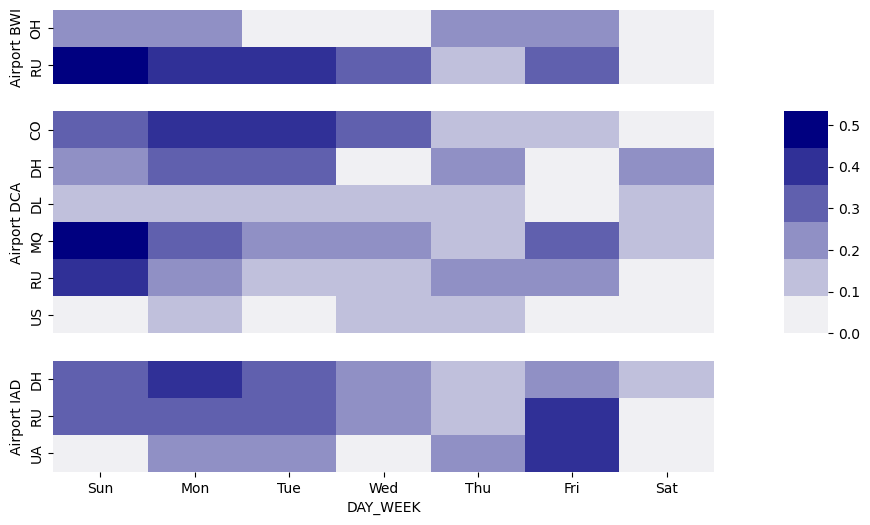

In [141]:
agg = delays_df.groupby(['ORIGIN', 'DAY_WEEK', 'CARRIER']).isDelayed.mean()
agg = agg.reset_index()

# Define the layout of the graph
height_ratios = []
for i, origin in enumerate(sorted(delays_df.ORIGIN.unique())):
    height_ratios.append(len(agg[agg.ORIGIN == origin].CARRIER.unique()))
gridspec_kw = {'height_ratios': height_ratios, 'width_ratios': [15, 1]}
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10, 6), 
                         gridspec_kw = gridspec_kw)
axes[0, 1].axis('off')
axes[2, 1].axis('off')

maxIsDelay = agg.isDelayed.max()
for i, origin in enumerate(sorted(delays_df.ORIGIN.unique())):
    data = pd.pivot_table(agg[agg.ORIGIN == origin], values='isDelayed', aggfunc=np.sum, 
                          index=['CARRIER'], columns=['DAY_WEEK'])
    data = data[[7, 1, 2, 3, 4, 5, 6]]  # Shift last columns to first
    ax = sns.heatmap(data, ax=axes[i][0], vmin=0, vmax=maxIsDelay, 
                     cbar_ax=axes[1][1], cmap=sns.light_palette("navy"))
    ax.set_xticklabels(['Sun', 'Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat'])
    if i != 2: 
        ax.get_xaxis().set_visible(False)
    ax.set_ylabel('Airport ' + origin)
    

plt.show()

## Table 10.8

In [142]:
delays_df = pd.read_csv(DATA / 'FlightDelays.csv')
# Create an indicator variable
delays_df['isDelayed'] = [1 if status == 'delayed' else 0 
                          for status in delays_df['Flight Status']]

# convert to categorical
delays_df.DAY_WEEK = delays_df.DAY_WEEK.astype('category')

# create hourly bins departure time 
delays_df.CRS_DEP_TIME = [round(t / 100) for t in delays_df.CRS_DEP_TIME]
delays_df.CRS_DEP_TIME = delays_df.CRS_DEP_TIME.astype('category')

predictors = ['DAY_WEEK', 'CRS_DEP_TIME', 'ORIGIN', 'DEST', 'CARRIER', 'Weather']
outcome = 'isDelayed'

X = pd.get_dummies(delays_df[predictors], drop_first=True)
y = delays_df[outcome]
classes = ['ontime', 'delayed']

# split into training and validation
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, 
                                                      random_state=1)

logit_full = LogisticRegression(penalty="l2", C=1e42, solver='liblinear')
logit_full.fit(train_X, train_y)

pd.set_option('display.width', 95)
pd.set_option('display.precision',3)
pd.set_option('display.max_columns', 33)
print('intercept ', logit_full.intercept_[0])

print(pd.DataFrame({'coeff': logit_full.coef_[0]}, index=X.columns).transpose())
print()
print('AIC', AIC_score(valid_y, logit_full.predict(valid_X), df=len(train_X.columns) + 1))
pd.reset_option('display.width')
pd.reset_option('display.precision')
pd.reset_option('display.max_columns')

intercept  -1.2187584175492394
       Weather  DAY_WEEK_2  DAY_WEEK_3  DAY_WEEK_4  DAY_WEEK_5  DAY_WEEK_6  DAY_WEEK_7  \
coeff    9.327      -0.598      -0.705      -0.799      -0.296      -1.129      -0.135   

       CRS_DEP_TIME_7  CRS_DEP_TIME_8  CRS_DEP_TIME_9  CRS_DEP_TIME_10  CRS_DEP_TIME_11  \
coeff           0.631           0.382          -0.365            0.337            0.078   

       CRS_DEP_TIME_12  CRS_DEP_TIME_13  CRS_DEP_TIME_14  CRS_DEP_TIME_15  CRS_DEP_TIME_16  \
coeff            0.399            0.175            0.201            1.265            0.628   

       CRS_DEP_TIME_17  CRS_DEP_TIME_18  CRS_DEP_TIME_19  CRS_DEP_TIME_20  CRS_DEP_TIME_21  \
coeff            1.093            0.285            1.655            1.023            1.076   

       ORIGIN_DCA  ORIGIN_IAD  DEST_JFK  DEST_LGA  CARRIER_DH  CARRIER_DL  CARRIER_MQ  \
coeff       -0.01      -0.134    -0.524    -0.546       0.352      -0.684       0.743   

       CARRIER_OH  CARRIER_RU  CARRIER_UA  CARRI

In [143]:
# save a dataframe into a csv file
#train_X.to_csv(DATA / 'FlightDelays_train_X.csv', index=False)
#train_y.to_csv(DATA / 'FlightDelays_train_y.csv', index=False)
#valid_X.to_csv(DATA / 'FlightDelays_valid_X.csv', index=False)
#valid_y.to_csv(DATA / 'FlightDelays_valid_y.csv', index=False)

In [144]:
math.exp( -0.971)

0.37870414454364976

In [145]:
delays_df.CRS_DEP_TIME.dtypes

CategoricalDtype(categories=[6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21], ordered=False)

In [146]:
delays_df.CRS_DEP_TIME.value_counts()

15    292
17    241
16    178
8     164
12    142
21    137
7     133
13    132
6     126
14    123
19    119
9     108
10    100
18     85
11     68
20     53
Name: CRS_DEP_TIME, dtype: int64

## Figure 10.6

Confusion Matrix (Accuracy 0.8309)

        Prediction
 Actual  ontime delayed
 ontime     705       9
delayed     140      27


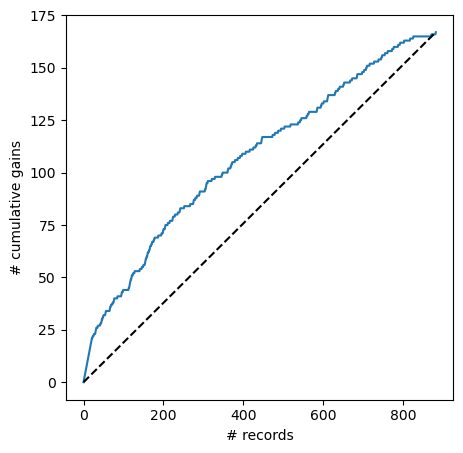

In [147]:
logit_reg_pred = logit_full.predict_proba(valid_X)
full_result = pd.DataFrame({'actual': valid_y, 
                            'p(0)': [p[0] for p in logit_reg_pred],
                            'p(1)': [p[1] for p in logit_reg_pred],
                            'predicted': logit_full.predict(valid_X)})
full_result = full_result.sort_values(by=['p(1)'], ascending=False)

# confusion matrix
classificationSummary(full_result.actual, full_result.predicted, class_names=classes)

gainsChart(full_result.actual, figsize=[5, 5])

plt.show()

In [148]:
delays_df = pd.read_csv(DATA / 'FlightDelays.csv')
# Create an indicator variable
delays_df['isDelayed'] = [1 if status == 'delayed' else 0 
                          for status in delays_df['Flight Status']]

# convert to categorical
delays_df.DAY_WEEK = delays_df.DAY_WEEK.astype('category')

# create hourly bins departure time 
delays_df.CRS_DEP_TIME = [round(t / 100) for t in delays_df.CRS_DEP_TIME]
delays_df.CRS_DEP_TIME = delays_df.CRS_DEP_TIME.astype('category')

predictors = ['DAY_WEEK', 'CRS_DEP_TIME', 'ORIGIN', 'DEST', 'CARRIER', 'Weather']
outcome = 'isDelayed'

X = pd.get_dummies(delays_df[predictors], drop_first=True)
y = delays_df[outcome]
classes = ['ontime', 'delayed']

# split into training and validation
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, 
                                                      random_state=1)

logit_full = LogisticRegression(penalty="l2", C=1e42, solver='liblinear', tol=1e-10)
logit_full.fit(train_X, train_y)

pd.set_option('display.width', 95)
pd.set_option('display.precision',4)
pd.set_option('display.max_columns', 33)
print('intercept ', logit_full.intercept_[0])

print(pd.DataFrame({'coeff': logit_full.coef_[0]}, index=X.columns).transpose())
print()
print('AIC', AIC_score(valid_y, logit_full.predict(valid_X), df=len(train_X.columns) + 1))
pd.reset_option('display.width')
pd.reset_option('display.precision')
pd.reset_option('display.max_columns')

intercept  -1.219313566180183
       Weather  DAY_WEEK_2  DAY_WEEK_3  DAY_WEEK_4  DAY_WEEK_5  DAY_WEEK_6  DAY_WEEK_7  \
coeff  23.3274     -0.5979     -0.7048     -0.7987     -0.2958     -1.1293     -0.1354   

       CRS_DEP_TIME_7  CRS_DEP_TIME_8  CRS_DEP_TIME_9  CRS_DEP_TIME_10  CRS_DEP_TIME_11  \
coeff          0.6316          0.3823          -0.365           0.3371           0.0785   

       CRS_DEP_TIME_12  CRS_DEP_TIME_13  CRS_DEP_TIME_14  CRS_DEP_TIME_15  CRS_DEP_TIME_16  \
coeff            0.399            0.175           0.2015           1.2648           0.6282   

       CRS_DEP_TIME_17  CRS_DEP_TIME_18  CRS_DEP_TIME_19  CRS_DEP_TIME_20  CRS_DEP_TIME_21  \
coeff           1.0929           0.2856           1.6555           1.0233           1.0766   

       ORIGIN_DCA  ORIGIN_IAD  DEST_JFK  DEST_LGA  CARRIER_DH  CARRIER_DL  CARRIER_MQ  \
coeff     -0.0095      -0.134   -0.5236   -0.5457      0.3524     -0.6845      0.7432   

       CARRIER_OH  CARRIER_RU  CARRIER_UA  CARRIE

In [149]:
# Use statsmodels
# add constant column

delays_df2 = sm.add_constant(delays_df[predictors], prepend=True)
X = pd.get_dummies(delays_df2, drop_first=True)
y = delays_df[outcome]
classes = ['ontime', 'delayed']

# split into training and validation
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, 
                                                      random_state=1)
logit_reg = sm.GLM(train_y, train_X, family=sm.families.Binomial())
logit_result = logit_reg.fit()
print(logit_result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:              isDelayed   No. Observations:                 1320
Model:                            GLM   Df Residuals:                     1286
Model Family:                Binomial   Df Model:                           33
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -566.44
Date:                Thu, 23 Feb 2023   Deviance:                       1132.9
Time:                        23:45:11   Pearson chi2:                 1.33e+03
No. Iterations:                    21   Pseudo R-squ. (CS):             0.1274
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const              -1.2193      0.708     

In [150]:
math.exp(-0.9714)

0.37855269317812473

In [151]:
math.exp(23.7375)

20373482199.04157

## Interpret all coefficients above.

In [152]:
X

,const,Weather,DAY_WEEK_2,DAY_WEEK_3,DAY_WEEK_4,DAY_WEEK_5,DAY_WEEK_6,DAY_WEEK_7,CRS_DEP_TIME_7,CRS_DEP_TIME_8,...,ORIGIN_IAD,DEST_JFK,DEST_LGA,CARRIER_DH,CARRIER_DL,CARRIER_MQ,CARRIER_OH,CARRIER_RU,CARRIER_UA,CARRIER_US
0,1.0,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
1,1.0,0,0,0,1,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
2,1.0,0,0,0,1,0,0,0,0,0,...,1,0,1,1,0,0,0,0,0,0
3,1.0,0,0,0,1,0,0,0,0,0,...,1,0,1,1,0,0,0,0,0,0
4,1.0,0,0,0,1,0,0,0,0,0,...,1,0,1,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2196,1.0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2197,1.0,0,0,0,0,0,1,0,0,0,...,1,0,0,0,0,0,0,1,0,0
2198,1.0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2199,1.0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0


### The model classifies ontime flights more accurately and is less accurate in classifying flights that were delayed. If there is an asymmetric cost structure so that one type of misclassification is more costly than the other, the cutoff value can be selected to minimize the cost. Of course, this tweaking should be carried out on the training data and assessed only using the validation data.

### In most conceivable situations, the purpose of the model would be to identify those flights most likely to be delayed among a set of flights, so that resources can be directed toward either reducing the delay or mitigating its effects. Air traffic controllers might work to open up additional air routes or allocate more controllers to a specific area for a short time. Airlines might bring on personnel to rebook passengers and to activate standby flight crews and aircraft. Hotels might allocate space for stranded travellers. In all cases, the resources available are going to be limited and might vary over time and from organization to organization. In this situation, the most useful model would provide an ordering of flights by their probability of delay, letting the users decide how far down that list to go in taking action. Therefore, model lift is a useful measure of performance—as you move down that list of flights, ordered by their delay probability, how much better does the model do in predicting delay than would a naive model which is simply the average delay rate for all flights? From the gains curve for the validation data (Figure 10.6), we see that this model is superior to the baseline (simple random selection of flights).

## Variable Selection

### Drop: Departure Airport, Destination Airport.
### Regroup carriers, day of week, hour of day into fewer categories that are more distinguishable with respect to delays.
### Regularization, automated variable selection approach (parsimonious).

In [153]:
delays_df = pd.read_csv(DATA / 'FlightDelays.csv')
# Create an indicator variable
delays_df['isDelayed'] = [1 if status == 'delayed' else 0 
                          for status in delays_df['Flight Status']]

# convert to categorical
delays_df.DAY_WEEK = delays_df.DAY_WEEK.astype('category')

# create hourly bins departure time 
delays_df.CRS_DEP_TIME = [round(t / 100) for t in delays_df.CRS_DEP_TIME]
delays_df.CRS_DEP_TIME = delays_df.CRS_DEP_TIME.astype('category')

predictors = ['DAY_WEEK', 'CRS_DEP_TIME', 'ORIGIN', 'DEST', 'CARRIER', 'Weather']
outcome = 'isDelayed'

X = pd.get_dummies(delays_df[predictors], drop_first=True)
y = delays_df[outcome]
classes = ['ontime', 'delayed']

# split into training and validation
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, 
                                                      random_state=1)

In [154]:
# logit_reg_L1 = LogisticRegressionCV(penalty='l1',  solver='saga', cv=5, random_state=0, Cs=20, max_iter=10000)
logit_reg_L1 = LogisticRegressionCV(penalty="l1", solver='liblinear', cv=10, random_state=1, Cs=20, tol=1e-4, max_iter=10000)
logit_reg_L1.fit(train_X, train_y)

LogisticRegressionCV(Cs=20, cv=10, max_iter=10000, penalty='l1', random_state=1,
                     solver='liblinear')

In [155]:
pd.set_option('display.width', 95)
pd.set_option('display.precision',3)
pd.set_option('display.max_columns', 40)
print('intercept ', logit_reg_L1.intercept_[0])

print(pd.DataFrame({'coeff': logit_reg_L1.coef_[0]}, index=X.columns).transpose())
print()
print('AIC', AIC_score(valid_y, logit_reg_L1.predict(valid_X), df=len(train_X.columns) + 1))
pd.reset_option('display.width')
pd.reset_option('display.precision')
pd.reset_option('display.max_columns')

intercept  -1.1162039297006914
       Weather  DAY_WEEK_2  DAY_WEEK_3  DAY_WEEK_4  DAY_WEEK_5  DAY_WEEK_6  DAY_WEEK_7  \
coeff    1.655      -0.044      -0.231      -0.364         0.0       -0.61       0.042   

       CRS_DEP_TIME_7  CRS_DEP_TIME_8  CRS_DEP_TIME_9  CRS_DEP_TIME_10  CRS_DEP_TIME_11  \
coeff             0.0             0.0          -0.077              0.0              0.0   

       CRS_DEP_TIME_12  CRS_DEP_TIME_13  CRS_DEP_TIME_14  CRS_DEP_TIME_15  CRS_DEP_TIME_16  \
coeff              0.0              0.0              0.0            0.465              0.0   

       CRS_DEP_TIME_17  CRS_DEP_TIME_18  CRS_DEP_TIME_19  CRS_DEP_TIME_20  CRS_DEP_TIME_21  \
coeff            0.361              0.0            0.782              0.0            0.263   

       ORIGIN_DCA  ORIGIN_IAD  DEST_JFK  DEST_LGA  CARRIER_DH  CARRIER_DL  CARRIER_MQ  \
coeff      -0.072         0.0       0.0    -0.137         0.0      -0.691       0.316   

       CARRIER_OH  CARRIER_RU  CARRIER_UA  CARRI

In [156]:
# penalty='elasticnet'
# Standardize the data
from sklearn.preprocessing import StandardScaler
# Initiate scaler
sc = StandardScaler()
# Standardize the training dataset
X_train_transformed = pd.DataFrame(sc.fit_transform(train_X),index=train_X.index, columns=train_X.columns)
# Standardized the testing dataset
X_valid_transformed = pd.DataFrame(sc.transform(valid_X),index=valid_X.index, columns=valid_X.columns)
# Summary statistics after standardization
X_train_transformed.describe().T

,count,mean,std,min,25%,50%,75%,max
Weather,1320.0,-6.468100e-16,1.000379,-0.095783,-0.095783,-0.095783,-0.095783,10.440307
DAY_WEEK_2,1320.0,-6.888429e-17,1.000379,-0.408789,-0.408789,-0.408789,-0.408789,2.446248
DAY_WEEK_3,1320.0,-1.672904e-16,1.000379,-0.401186,-0.401186,-0.401186,-0.401186,2.492612
DAY_WEEK_4,1320.0,-7.737918e-18,1.000379,-0.450868,-0.450868,-0.450868,-0.450868,2.217946
DAY_WEEK_5,1320.0,2.247361e-16,1.000379,-0.456937,-0.456937,-0.456937,-0.456937,2.188487
DAY_WEEK_6,1320.0,-1.829345e-16,1.000379,-0.374027,-0.374027,-0.374027,-0.374027,2.673602
DAY_WEEK_7,1320.0,-5.963243e-17,1.000379,-0.362085,-0.362085,-0.362085,-0.362085,2.761784
CRS_DEP_TIME_7,1320.0,-1.579545e-16,1.000379,-0.255686,-0.255686,-0.255686,-0.255686,3.911048
CRS_DEP_TIME_8,1320.0,-2.077463e-17,1.000379,-0.297003,-0.297003,-0.297003,-0.297003,3.366964
CRS_DEP_TIME_9,1320.0,-1.640523e-16,1.000379,-0.227580,-0.227580,-0.227580,-0.227580,4.394052


In [157]:
# Summary statistics before standardization
train_X.describe().T

,count,mean,std,min,25%,50%,75%,max
Weather,1320.0,0.009091,0.094948,0.0,0.0,0.0,0.0,1.0
DAY_WEEK_2,1320.0,0.143182,0.350391,0.0,0.0,0.0,0.0,1.0
DAY_WEEK_3,1320.0,0.138636,0.345698,0.0,0.0,0.0,0.0,1.0
DAY_WEEK_4,1320.0,0.168939,0.374840,0.0,0.0,0.0,0.0,1.0
DAY_WEEK_5,1320.0,0.172727,0.378155,0.0,0.0,0.0,0.0,1.0
DAY_WEEK_6,1320.0,0.122727,0.328248,0.0,0.0,0.0,0.0,1.0
DAY_WEEK_7,1320.0,0.115909,0.320237,0.0,0.0,0.0,0.0,1.0
CRS_DEP_TIME_7,1320.0,0.061364,0.240087,0.0,0.0,0.0,0.0,1.0
CRS_DEP_TIME_8,1320.0,0.081061,0.273032,0.0,0.0,0.0,0.0,1.0
CRS_DEP_TIME_9,1320.0,0.049242,0.216456,0.0,0.0,0.0,0.0,1.0


In [158]:
# L1 lasso
logit_reg_L1 = LogisticRegression(penalty="l1", solver='saga', random_state=1, 
                                  tol=1e-8, max_iter=100000)
logit_reg_L1.fit(X_train_transformed, train_y)
pd.set_option('display.width', 95)
pd.set_option('display.precision',3)
pd.set_option('display.max_columns', 40)
print('intercept ', logit_reg_L1.intercept_[0])

print(pd.DataFrame({'coeff': logit_reg_L1.coef_[0]}, index=X.columns).transpose())
print()
print('AIC', AIC_score(valid_y, logit_reg_L1.predict(X_valid_transformed), 
                       df=len(X_train_transformed.columns) + 1))
pd.reset_option('display.width')
pd.reset_option('display.precision')
pd.reset_option('display.max_columns')

intercept  -1.6167166151065764
       Weather  DAY_WEEK_2  DAY_WEEK_3  DAY_WEEK_4  DAY_WEEK_5  DAY_WEEK_6  DAY_WEEK_7  \
coeff    0.577      -0.177      -0.213      -0.266      -0.081      -0.337      -0.014   

       CRS_DEP_TIME_7  CRS_DEP_TIME_8  CRS_DEP_TIME_9  CRS_DEP_TIME_10  CRS_DEP_TIME_11  \
coeff           0.087           0.038          -0.118            0.012           -0.018   

       CRS_DEP_TIME_12  CRS_DEP_TIME_13  CRS_DEP_TIME_14  CRS_DEP_TIME_15  CRS_DEP_TIME_16  \
coeff            0.034           -0.011              0.0             0.34            0.099   

       CRS_DEP_TIME_17  CRS_DEP_TIME_18  CRS_DEP_TIME_19  CRS_DEP_TIME_20  CRS_DEP_TIME_21  \
coeff            0.262              0.0            0.304            0.109            0.196   

       ORIGIN_DCA  ORIGIN_IAD  DEST_JFK  DEST_LGA  CARRIER_DH  CARRIER_DL  CARRIER_MQ  \
coeff         0.0      -0.013    -0.162    -0.225       0.092      -0.276       0.226   

       CARRIER_OH  CARRIER_RU  CARRIER_UA  CARRI

In [159]:
logit_reg_elasticnet = LogisticRegression(penalty='elasticnet', 
    solver='saga', random_state=1, l1_ratio=0.5, tol=1e-8, max_iter=100000)

logit_reg_elasticnet.fit(X_train_transformed, train_y)
pd.set_option('display.width', 95)
pd.set_option('display.precision',3)
pd.set_option('display.max_columns', 40)
print('intercept ', logit_reg_elasticnet.intercept_[0])

print(pd.DataFrame({'coeff': logit_reg_elasticnet.coef_[0]}, index=X.columns).transpose())
print()
print('AIC', AIC_score(valid_y, logit_reg_elasticnet.predict(valid_X), df=len(train_X.columns) + 1))
pd.reset_option('display.width')
pd.reset_option('display.precision')
pd.reset_option('display.max_columns')

intercept  -1.6211254190386215
       Weather  DAY_WEEK_2  DAY_WEEK_3  DAY_WEEK_4  DAY_WEEK_5  DAY_WEEK_6  DAY_WEEK_7  \
coeff    0.598       -0.19      -0.225      -0.279      -0.093       -0.35      -0.026   

       CRS_DEP_TIME_7  CRS_DEP_TIME_8  CRS_DEP_TIME_9  CRS_DEP_TIME_10  CRS_DEP_TIME_11  \
coeff           0.104           0.054          -0.111            0.029           -0.013   

       CRS_DEP_TIME_12  CRS_DEP_TIME_13  CRS_DEP_TIME_14  CRS_DEP_TIME_15  CRS_DEP_TIME_16  \
coeff            0.051              0.0            0.003            0.364            0.117   

       CRS_DEP_TIME_17  CRS_DEP_TIME_18  CRS_DEP_TIME_19  CRS_DEP_TIME_20  CRS_DEP_TIME_21  \
coeff            0.283            0.014            0.321            0.122            0.211   

       ORIGIN_DCA  ORIGIN_IAD  DEST_JFK  DEST_LGA  CARRIER_DH  CARRIER_DL  CARRIER_MQ  \
coeff         0.0      -0.034    -0.177    -0.246       0.121      -0.268        0.24   

       CARRIER_OH  CARRIER_RU  CARRIER_UA  CARRI

### Table 10.10

In [160]:
delays_df = pd.read_csv(DATA / 'FlightDelays.csv')
delays_df['isDelayed'] = [1 if status == 'delayed' else 0 
                          for status in delays_df['Flight Status']]
delays_df['CRS_DEP_TIME'] = [round(t / 100) for t in delays_df['CRS_DEP_TIME']]
delays_red_df = pd.DataFrame({
    'Sun_Mon' : [1 if d in (1, 7) else 0 for d in delays_df.DAY_WEEK],
    'Weather' : delays_df.Weather,
    'CARRIER_CO_MQ_DH_RU' : [1 if d in ("CO", "MQ", "DH", "RU") else 0 
                             for d in delays_df.CARRIER],
    'MORNING' : [1 if d in (6, 7, 8, 9) else 0 for d in delays_df.CRS_DEP_TIME],
    'NOON' : [1 if d in (10, 11, 12, 13) else 0 for d in delays_df.CRS_DEP_TIME],
    'AFTER2P' : [1 if d in (14, 15, 16, 17, 18) else 0 for d in delays_df.CRS_DEP_TIME],
    'EVENING' : [1 if d in (19, 20) else 0 for d in delays_df.CRS_DEP_TIME],
    'isDelayed' : [1 if status == 'delayed' else 0 for status in delays_df['Flight Status']],
})

X = delays_red_df.drop(columns=['isDelayed'])
y = delays_red_df['isDelayed']
classes = ['ontime', 'delayed']

# split into training and validation
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, 
                                                      random_state=1)
# Make correction in Table 10.10. Don't need regularization for groups/dropped predictors
logit_red = LogisticRegression(penalty='none', max_iter=10000, tol=1e-8)
logit_red.fit(train_X, train_y)

pd.set_option('display.width', 100)
# print('regularization', logit_red.C_)
print('intercept ', logit_red.intercept_[0])
print(pd.DataFrame({'coeff': logit_red.coef_[0]}, index=X.columns).transpose())
pd.reset_option('display.width')
print('AIC', AIC_score(valid_y, logit_red.predict(valid_X), df=len(train_X.columns) + 1))


# confusion matrix
classificationSummary(valid_y, logit_red.predict(valid_X), class_names=classes)

intercept  -2.293922350017731
        Sun_Mon    Weather  CARRIER_CO_MQ_DH_RU   MORNING     NOON   AFTER2P   EVENING
coeff  0.589644  17.691474             1.325641 -0.614137 -0.69789 -0.079947  0.567826
AIC 934.6153607819037
Confusion Matrix (Accuracy 0.8343)

        Prediction
 Actual  ontime delayed
 ontime     711       3
delayed     143      24


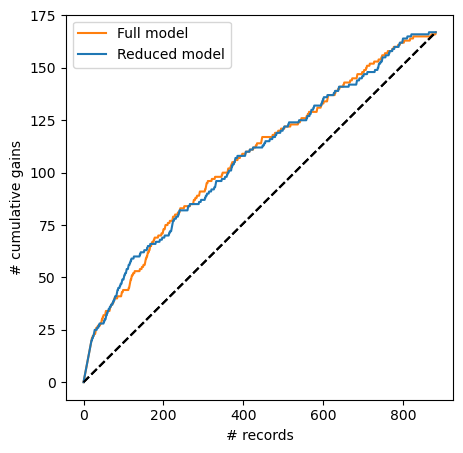

In [161]:
logit_reg_proba = logit_red.predict_proba(valid_X)
red_result = pd.DataFrame({'actual': valid_y, 
                            'p(0)': [p[0] for p in logit_reg_proba],
                            'p(1)': [p[1] for p in logit_reg_proba],
                            'predicted': logit_red.predict(valid_X),
                          })
red_result = red_result.sort_values(by=['p(1)'], ascending=False)

ax = gainsChart(full_result.actual, label='Full model', color='C1', figsize=[5, 5])
ax = gainsChart(red_result.actual, label='Reduced model', color='C0', ax=ax)
ax.legend()

plt.show()

In [162]:
# Using statsmodels
# add constant column
train_X2 = sm.add_constant(train_X, prepend=True)
logit_reg2 = sm.GLM(train_y, train_X2, family=sm.families.Binomial())
logit_result2 = logit_reg2.fit()
logit_result2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              isDelayed   No. Observations:                 1320
Model:                            GLM   Df Residuals:                     1312
Model Family:                Binomial   Df Model:                            7
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -583.70
Date:                Thu, 23 Feb 2023   Deviance:                       1167.4
Time:                        23:45:30   Pearson chi2:                 1.32e+03
No. Iterations:                    21   Pseudo R-squ. (CS):             0.1042
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  -2.2939      0.312     -7.351      0.000      -2.906      -1.682
Sun_Mon                 0.5897      0.159      3.717      0.000       0.279       0.901
Weather                24.0089   1.32e+04      0.002      0.999   -2.59e+04     2.6e+04
CARRIER_CO_MQ_DH_RU     1.3256      0.182      7.295      0.000       0.969       1.682
MORNING                -0.6141      0.308     -1.996      0.046      -1.217      -0.011
NOON                   -0.6979      0.319     -2.188      0.029      -1.323      -0.073
AFTER2P                -0.0799      0.278     -0.287      0.774      -0.626       0.466
EVENING                 0.5677      0.353      1.608      0.108      -0.124       1.260
=======================================================================================
"""

### Conclusion: the highest chance of an ontime flight from DC to New York is on Tuesday–Saturday in the morning on Delta, Comair, United, or USAirways. And clearly, good weather is advantageous!

## Table 10.11

In [163]:
# same initial preprocessing and creating dummies

# add constant column
bank_df = sm.add_constant(bank_df, prepend=True)

y = bank_df['Personal_Loan']
X = bank_df.drop(columns=['Personal_Loan'])

# partition data
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

# use GLM (Generalized Linear Model) with the binomial family to fit a logistic regression
logit_reg = sm.GLM(train_y, train_X, family=sm.families.Binomial())
logit_result = logit_reg.fit()
print(logit_result.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:          Personal_Loan   No. Observations:                 3000
Model:                            GLM   Df Residuals:                     2987
Model Family:                Binomial   Df Model:                           12
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -340.15
Date:                Thu, 23 Feb 2023   Deviance:                       680.30
Time:                        23:45:31   Pearson chi2:                 8.10e+03
No. Iterations:                     8   Pseudo R-squ. (CS):             0.3325
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                -12.5634      2

In [164]:
logitL1=sm.Logit(train_y,train_X)
result=logitL1.fit_regularized(method='l1')
print(result.summary())

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.1133826685956016
            Iterations: 90
            Function evaluations: 99
            Gradient evaluations: 90
                           Logit Regression Results                           
Dep. Variable:          Personal_Loan   No. Observations:                 3000
Model:                          Logit   Df Residuals:                     2987
Method:                           MLE   Df Model:                           12
Date:                Thu, 23 Feb 2023   Pseudo R-squ.:                  0.6406
Time:                        23:45:31   Log-Likelihood:                -340.15
converged:                       True   LL-Null:                       -946.37
Covariance Type:            nonrobust   LLR p-value:                3.627e-252
                         coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------

/Users/min/opt/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
/Users/min/opt/anaconda3/lib/python3.9/site-packages/statsmodels/discrete/discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


In [165]:
bank_df

,const,Age,Experience,Income,Family,CCAvg,Mortgage,Personal_Loan,Securities_Account,CD_Account,Online,CreditCard,Education_2,Education_3
0,1.0,25,1,49,4,1.6,0,0,1,0,0,0,0,0
1,1.0,45,19,34,3,1.5,0,0,1,0,0,0,0,0
2,1.0,39,15,11,1,1.0,0,0,0,0,0,0,0,0
3,1.0,35,9,100,1,2.7,0,0,0,0,0,0,1,0
4,1.0,35,8,45,4,1.0,0,0,0,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,1.0,29,3,40,1,1.9,0,0,0,0,1,0,0,1
4996,1.0,30,4,15,4,0.4,85,0,0,0,1,0,0,0
4997,1.0,63,39,24,2,0.3,0,0,0,0,0,0,0,1
4998,1.0,65,40,49,3,0.5,0,0,0,0,1,0,1,0


In [166]:
data = pd.read_csv(DATA / 'accidentsFull.csv')
outcome = 'MAX_SEV_IR'
predictors = ['ALCHL_I', 'WEATHER_R']

y = data[outcome]
X = data[predictors]
train_X, train_y = X, y
classes = sorted(y.unique())

print('Nominal logistic regression')
logit = LogisticRegression(penalty="l2", solver='lbfgs', C=1e24, multi_class='multinomial')
logit.fit(X, y)
print('  intercept', logit.intercept_)
print('  coefficients', logit.coef_)
print()
probs = logit.predict_proba(X)
results = pd.DataFrame({
    'actual': y, 'predicted': logit.predict(X),
    'P(0)': [p[0] for p in probs],
    'P(1)': [p[1] for p in probs],
    'P(2)': [p[2] for p in probs],
})
print(results.head())
print()


print('Ordinal logistic regression')
logit = LogisticIT(alpha=0)
logit.fit(X, y)
print('  theta', logit.theta_)
print('  coefficients', logit.coef_)
print()
probs = logit.predict_proba(X)
results = pd.DataFrame({
    'actual': y, 'predicted': logit.predict(X),
    'P(0)': [p[0] for p in probs],
    'P(1)': [p[1] for p in probs],
    'P(2)': [p[2] for p in probs],
})
print(results.head())

Nominal logistic regression
  intercept [-0.09100315  0.9036454  -0.81264225]
  coefficients [[ 0.51606685  0.3391015 ]
 [ 0.14900396  0.09543369]
 [-0.66507082 -0.43453518]]

   actual  predicted      P(0)      P(1)      P(2)
0       1          1  0.490649  0.498989  0.010362
1       0          0  0.553461  0.441147  0.005392
2       0          0  0.553461  0.441147  0.005392
3       0          1  0.490649  0.498989  0.010362
4       0          1  0.394192  0.578684  0.027124

Ordinal logistic regression
  theta [-1.06916285  2.77444326]
  coefficients [-0.40112008 -0.25174207]

   actual  predicted      P(0)      P(1)      P(2)
0       1          1  0.496205  0.482514  0.021281
1       0          0  0.558866  0.424510  0.016624
2       0          0  0.558866  0.424510  0.016624
3       0          1  0.496205  0.482514  0.021281
4       0          1  0.397402  0.571145  0.031453


## Nominal logistic regression

In [167]:
data = pd.read_csv(DATA / 'accidentsFull.csv')
outcome = 'MAX_SEV_IR'
predictors = ['ALCHL_I', 'WEATHER_R']
print('predictors', predictors)
print()
y = data[outcome]
X = data[predictors]
train_X, train_y = X, y
classes = sorted(y.unique())

logit = LogisticRegression(penalty="l2", solver='lbfgs', C=1e24, multi_class='multinomial')
logit.fit(X, y)

print('intercept', logit.intercept_)
print('coef', logit.coef_)
print('classes', logit.classes_)

probs = logit.predict_proba(X)
results = pd.DataFrame({
    'actual': y,
    'predicted': logit.predict(X),
    'P(a)': [p[0] for p in probs],
    'P(b)': [p[1] for p in probs],
    'P(c)': [p[2] for p in probs],
})
print(results.head())
# classificationSummary(y, results.predicted, class_names=classes)

predictors ['ALCHL_I', 'WEATHER_R']

intercept [-0.09100315  0.9036454  -0.81264225]
coef [[ 0.51606685  0.3391015 ]
 [ 0.14900396  0.09543369]
 [-0.66507082 -0.43453518]]
classes [0 1 2]
   actual  predicted      P(a)      P(b)      P(c)
0       1          1  0.490649  0.498989  0.010362
1       0          0  0.553461  0.441147  0.005392
2       0          0  0.553461  0.441147  0.005392
3       0          1  0.490649  0.498989  0.010362
4       0          1  0.394192  0.578684  0.027124


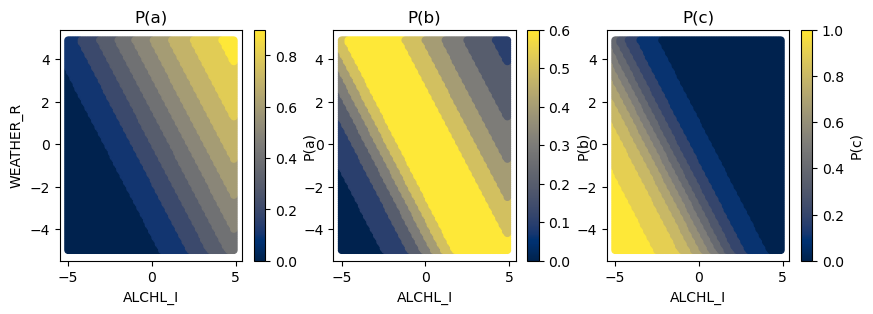

In [168]:
def plotProbabilities(model):
    n = 100
    Xtest = pd.DataFrame({
        'ALCHL_I': [(i % n) * 0.1 + (j // n) * 0.1 - 5 for i in range(n) for j in range(n)],
        'WEATHER_R': [(i // n) * 0.1 + (j % n) * 0.1 - 5 for i in range(n) for j in range(n)],
    })
    probs = logit.predict_proba(Xtest[predictors])

    results = pd.DataFrame({
        'predicted': logit.predict(Xtest[predictors]),
        'P(a)': [round(10 * p[0]) / 10 for p in probs],
        'P(b)': [round(10 * p[1]) / 10 for p in probs],
        'P(c)': [round(10 * p[2]) / 10 for p in probs],
    })
    mapped = pd.concat([results, Xtest], axis=1, sort=False)

    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 3))
    for i, c in enumerate(['P(a)', 'P(b)', 'P(c)']):
        ax = mapped.plot.scatter(x='ALCHL_I', y='WEATHER_R', c=c, title=c, colormap='cividis', ax=axes[i])
        if i > 0: ax.set_ylabel('')
plotProbabilities(logit)

## Ordinal logistic regression

In [169]:
import random
from mord import LogisticIT

data = pd.read_csv(DATA / 'accidentsFull.csv')
outcome = 'MAX_SEV_IR'
predictors = ['ALCHL_I', 'WEATHER_R']
y = data[outcome]
X = data[predictors]
X['ALCHL_I']
train_X, train_y = X, y
classes = sorted(y.unique())

logit = LogisticIT(alpha=0)
logit.fit(X, y)

print('theta', logit.theta_)
print('coef', logit.coef_)
print('classes', logit.classes_)
print()


probs = logit.predict_proba(X)

results = pd.DataFrame({
    'actual': [yi + random.gauss(0, 0.001) for yi in y],
    'predicted': logit.predict(X),
    'P(a)': [p[0] + random.gauss(0, 0.001) for p in probs],
    'P(b)': [p[1] + random.gauss(0, 0.001) for p in probs],
    'P(c)': [p[2] + random.gauss(0, 0.001) for p in probs],
})
print(results.head())

# classificationSummary(y, results.predicted, class_names=classes)

theta [-1.06916285  2.77444326]
coef [-0.40112008 -0.25174207]
classes [0 1 2]

     actual  predicted      P(a)      P(b)      P(c)
0  0.999109          1  0.495218  0.484212  0.020567
1  0.001588          0  0.557372  0.422895  0.017628
2 -0.000817          0  0.557951  0.424406  0.018826
3 -0.000307          1  0.495710  0.483259  0.020864
4 -0.001167          1  0.397569  0.570647  0.032872


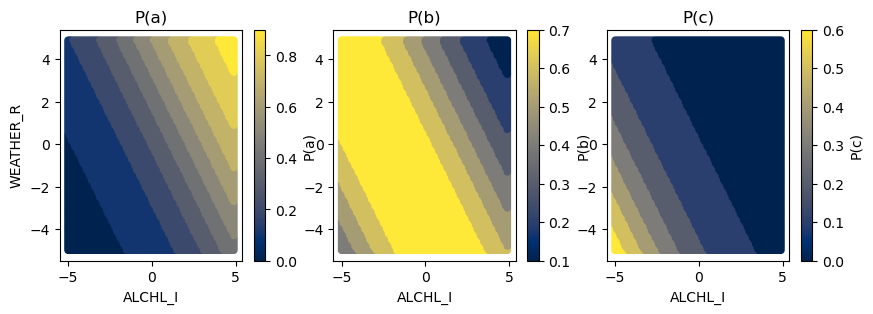

In [170]:
plotProbabilities(logit)

In [171]:
import sys
import sklearn
print(sys.version)
print('The scikit-learn version is {}.'.format(sklearn.__version__))

3.9.13 (main, Oct 13 2022, 16:12:30) 
[Clang 12.0.0 ]
The scikit-learn version is 1.0.2.
